In [ ]:
pip install ticketpy


In [ ]:
 pip install pytrends

In [ ]:
import ticketpy
from ticketpy.model import Venue, Event, Attraction, Classification

In [ ]:
from pytrends.request import TrendReq

In [ ]:
pytrend = TrendReq()

In [ ]:
pytrend.build_payload(kw_list=['Taylor Swift'])

#df = pytrend.interest_by_region()


In [ ]:
df = pytrend.trending_searches(pn="españa")


KeyError: 'españa'

In [ ]:
from pytrends.request import TrendReq

# Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq()

# Create payload and capture API tokens. Only needed for interest_over_time(), interest_by_region() & related_queries()
pytrend.build_payload(kw_list=['Taylor Swift'])

# Interest Over Time
interest_over_time_df = pytrend.interest_over_time()
print(interest_over_time_df.head())

# Interest by Region
interest_by_region_df = pytrend.interest_by_region()
print(interest_by_region_df.head())

# Related Queries, returns a dictionary of dataframes
related_queries_dict = pytrend.related_queries()
print(related_queries_dict)

# Get Google Hot Trends data
trending_searches_df = pytrend.trending_searches()
print(trending_searches_df.head())

# Get Google Hot Trends data
today_searches_df = pytrend.today_searches()
print(today_searches_df.head())

# Get Google Top Charts
top_charts_df = pytrend.top_charts(2018, hl='en-US', tz=300, geo='GLOBAL')
print(top_charts_df.head())

# Get Google Keyword Suggestions
suggestions_dict = pytrend.suggestions(keyword='pizza')
print(suggestions_dict)

# Get Google Realtime Search Trends
realtime_searches = pytrend.realtime_trending_searches(pn='IN')
print(realtime_searches.head())

# Recreate payload with multiple timeframes
pytrend.build_payload(kw_list=['pizza', 'bagel'], timeframe=['2022-09-04 2022-09-10', '2022-09-18 2022-09-24'])

# Multirange Interest Over Time
multirange_interest_over_time_df = pytrend.multirange_interest_over_time()
print(multirange_interest_over_time_df.head())

In [ ]:
import requests
import pandas as pd
import time
import math
from pathlib import Path


In [ ]:

url = "https://app.ticketmaster.com/discovery/v2/events?apikey=4uZ7cKblFpFckdrfHMGrT2coHBKCiAjs&locale=*&countryCode=ES&classificationName=music"

r = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
print(r.status_code)

# respuesta es un diccionario con 3 claves
respuesta = r.json()

links = respuesta['_links']
print(links)

datos = respuesta['_embedded']

pages = respuesta['page']
print(pages)

datos

df = pd.DataFrame(datos['events']) #para constriur el dataframe con los eventos
len(df)
# if r.status_code == 200:
#     # Imprimir la respuesta en formato JSON
#     #print(response.json())
#     df = pd.DataFrame(r.json()) # Utilizar pd.json_normalize para manejar datos anidados si es necesario

# else:
#     # Manejar el error si la solicitud no fue exitosa
#     print(f"Error: {r.status_code}")
#     print(r.text)  # Puedes imprimir el texto de la respuesta para obtener más detalles del error si es necesario


# df

200
{'first': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*&page=0&size=20'}, 'self': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*'}, 'next': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*&page=1&size=20'}, 'last': {'href': '/discovery/v2/events?countryCode=ES&classificationName=music&locale=*&page=44&size=20'}}
{'size': 20, 'totalElements': 896, 'totalPages': 45, 'number': 0}


20

In [ ]:
pag = 0
url = 'https://app.ticketmaster.com/discovery/v2/events?apikey=4uZ7cKblFpFckdrfHMGrT2coHBKCiAjs&countryCode=ES&classificationName=music&locale=*&page=' + str(pag)
r = requests.get(url)

if r.status_code == 200:
  respuesta = r.json()
  total_pages = respuesta['page']['totalPages']
  print(total_pages)
  df_datos = pd.DataFrame(respuesta['_embedded']['events'])
  pag += 1
  while(pag < total_pages):
    url = 'https://app.ticketmaster.com/discovery/v2/events?apikey=4uZ7cKblFpFckdrfHMGrT2coHBKCiAjs&countryCode=ES&classificationName=music&locale=*&page=' + str(pag)
    r = requests.get(url)
    res = r.json()
    df_datos_mas = pd.DataFrame(res['_embedded']['events'])
    df_datos = pd.concat([df_datos, df_datos_mas], ignore_index=True)
    pag += 1
else:
  print('Error: ' + r.status_code)
  print(r.text)


len(df_datos)

45


896

In [ ]:
df_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             896 non-null    object
 1   type             896 non-null    object
 2   id               896 non-null    object
 3   test             896 non-null    bool  
 4   url              896 non-null    object
 5   locale           896 non-null    object
 6   images           896 non-null    object
 7   sales            896 non-null    object
 8   dates            896 non-null    object
 9   classifications  896 non-null    object
 10  promoter         895 non-null    object
 11  promoters        895 non-null    object
 12  priceRanges      893 non-null    object
 13  _links           896 non-null    object
 14  _embedded        896 non-null    object
 15  seatmap          82 non-null     object
dtypes: bool(1), object(15)
memory usage: 106.0+ KB


In [ ]:
print(df_datos['type'].unique())    # la columna type toma únicamente el valor 'event' -> eliminar
df_datos_menos_col = df_datos.drop(columns = ['test', 'url','images',
                                              'promoters', 'type', 'locale',

                                              '_links', 'seatmap'])
#df_datos_menos_col['dates']
df_datos_menos_col.iloc[2]['classifications']

['event']


[{'primary': True,
  'segment': {'id': 'KZFzniwnSyZfZ7v7nn', 'name': 'Film'},
  'genre': {'id': 'KnvZfZ7vAkJ', 'name': 'Music'},
  'subGenre': {'id': 'KZazBEonSMnZfZ7vave', 'name': 'Music'},
  'family': False}]

In [ ]:
def obtener_start_datetime(fila):
    if 'access' in fila['dates'] and 'startDateTime' in fila['dates']['access']:
        return fila['dates']['access']['startDateTime']
    else:
        return None  # O un valor predeterminado que desees asignar cuando la clave no está presente

df_datos_menos_col['dates'] = df_datos_menos_col.apply(obtener_start_datetime,axis=1)


In [ ]:
def obtener_min_price(fila):
    if 'priceRanges' in fila and isinstance(fila['priceRanges'], list) and fila['priceRanges']:
        for price_range in fila['priceRanges']:
            if price_range.get('type') == 'standard':
                return price_range['min']
    return None

def obtener_max_price(fila):
    if 'priceRanges' in fila and isinstance(fila['priceRanges'], list) and fila['priceRanges']:
        for price_range in fila['priceRanges']:
            if price_range.get('type') == 'standard':
                return price_range['max']
    return None
# Aplicar las funciones a cada fila de la columna 'prices' y asignar los resultados a nuevas columnas 'min_price' y 'max_price'
df_datos_menos_col['min_price'] = df_datos_menos_col.apply(obtener_min_price, axis=1)
df_datos_menos_col['max_price'] = df_datos_menos_col.apply(obtener_max_price, axis=1)


In [ ]:
def obtener_start_datetime(fila):
        return fila['sales']['public'].get('startDateTime')

def obtener_end_datetime(fila):
    return fila['sales']['public'].get('endDateTime')


In [ ]:
df_datos_menos_col['StartTimeSale'] = df_datos_menos_col.apply(obtener_start_datetime, axis=1)
df_datos_menos_col['EndTimeSale'] = df_datos_menos_col.apply(obtener_end_datetime, axis=1)

In [ ]:
def obtener_promotor(fila):
    if 'promoter' in fila and isinstance(fila['promoter'], dict):
        return fila['promoter'].get('name')
    else:
        return None

df_datos_menos_col['Promotor'] = df_datos_menos_col.apply(obtener_promotor, axis=1)


In [ ]:
def obtener_genero(fila):
    if isinstance(fila['classifications'], list) and fila['classifications']:
        # Verifica si classifications es una lista no vacía
        for item in fila['classifications']:
            if 'genre' in item and isinstance(item['genre'], dict):
                return item['genre'].get('name')
    return None

def obtener_subgenero(fila):
    if isinstance(fila['classifications'], list) and fila['classifications']:
        for item in fila['classifications']:
            if 'subGenre' in item and isinstance(item['subGenre'], dict):
                return item['subGenre'].get('name')
    return None

df_datos_menos_col['Genero'] = df_datos_menos_col.apply(obtener_genero, axis=1)
df_datos_menos_col['Subgenero'] = df_datos_menos_col.apply(obtener_subgenero, axis=1)



In [ ]:
def venue_name(fila):
    return fila['_embedded']['venues'][0]['name']

def venue_city(fila):
  return fila['_embedded']['venues'][0]['city']['name']

def venue_state(fila):
  return fila['_embedded']['venues'][0]['state']['name']

def venue_country(fila):
  return fila['_embedded']['venues'][0]['country']['name']

df_datos_menos_col['VenueName'] = df_datos_menos_col.apply(venue_name, axis=1)
df_datos_menos_col['VenueCity'] = df_datos_menos_col.apply(venue_city, axis=1)
df_datos_menos_col['VenueState'] = df_datos_menos_col.apply(venue_state, axis=1)
df_datos_menos_col['VenueCountry'] = df_datos_menos_col.apply(venue_country, axis=1)

In [ ]:
# Calcular la media de los precios mínimos
media_precios_min = df_datos_menos_col['min_price'].mean()

# Calcular la mediana de los precios mínimos
mediana_precios_min = df_datos_menos_col['min_price'].median()

print("Media de los precios mínimos:", media_precios_min)
print("Mediana de los precios mínimos:", mediana_precios_min)


Media de los precios mínimos: 64.29818589025756
Mediana de los precios mínimos: 45.0


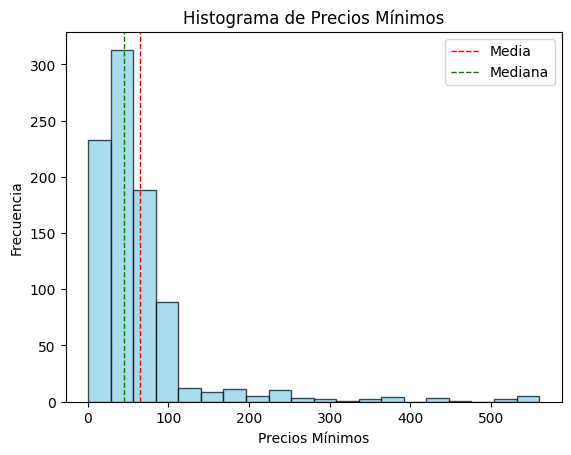

In [ ]:
import matplotlib.pyplot as plt

# Crear un histograma de los precios mínimos
plt.hist(df_datos_menos_col['min_price'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Agregar una línea vertical para la media
plt.axvline(media_precios_min, color='red', linestyle='dashed', linewidth=1, label='Media')

# Agregar una línea vertical para la mediana
plt.axvline(mediana_precios_min, color='green', linestyle='dashed', linewidth=1, label='Mediana')

# Etiquetas y título
plt.xlabel('Precios Mínimos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precios Mínimos')
plt.legend()

# Mostrar el histograma
plt.show()


In [ ]:
# Calcular la media de los precios mínimos
media_precios_max = df_datos_menos_col['max_price'].mean()

# Calcular la mediana de los precios mínimos
mediana_precios_max = df_datos_menos_col['max_price'].median()

print("Media de los precios máximos:", media_precios_max)
print("Mediana de los precios máximos:", mediana_precios_max)

In [ ]:
import matplotlib.pyplot as plt

# Crear un histograma de los precios mínimos
plt.hist(df_datos_menos_col['max_price'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Agregar una línea vertical para la media
plt.axvline(media_precios_max, color='red', linestyle='dashed', linewidth=1, label='Media')

# Agregar una línea vertical para la mediana
plt.axvline(mediana_precios_max, color='green', linestyle='dashed', linewidth=1, label='Mediana')

# Etiquetas y título
plt.xlabel('Precios Máximos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precios Máximos')
plt.legend()

# Mostrar el histograma
plt.show()

In [ ]:
# def genre_event(fila):
#   return fila['_embedded']['attractions'][0]['classifications'][0]['genre']['name']

def genre_event(fila):
    if '_embedded' in fila and 'attractions' in fila['_embedded'] and fila['_embedded']['attractions']:
        return fila['_embedded']['attractions'][0]['classifications'][0]['genre']['name']
    else:
        return None

def subgenre_event(fila):
    if '_embedded' in fila and 'attractions' in fila['_embedded'] and fila['_embedded']['attractions']:
        return fila['_embedded']['attractions'][0]['classifications'][0]['subGenre']['name']
    else:
        return None

def type_event(fila):
    if '_embedded' in fila and 'attractions' in fila['_embedded'] and fila['_embedded']['attractions']:
        return fila['_embedded']['attractions'][0]['classifications'][0]['type']['name']
    else:
        return None

def subtype_event(fila):
    if '_embedded' in fila and 'attractions' in fila['_embedded'] and fila['_embedded']['attractions']:
        return fila['_embedded']['attractions'][0]['classifications'][0]['subType']['name']
    else:
        return None

df_datos_menos_col['genre'] = df_datos_menos_col.apply(genre_event, axis = 1)
df_datos_menos_col['subGenre'] = df_datos_menos_col.apply(subgenre_event, axis = 1)
df_datos_menos_col['type'] = df_datos_menos_col.apply(type_event, axis = 1)
df_datos_menos_col['subType'] = df_datos_menos_col.apply(subtype_event, axis = 1)

df_datos_menos_col.iloc[1]['_embedded']['attractions'][0]['classifications'][0]
df_datos_menos_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             896 non-null    object 
 1   id               896 non-null    object 
 2   sales            896 non-null    object 
 3   dates            277 non-null    object 
 4   classifications  896 non-null    object 
 5   promoter         895 non-null    object 
 6   priceRanges      893 non-null    object 
 7   _embedded        896 non-null    object 
 8   min_price        893 non-null    float64
 9   max_price        893 non-null    float64
 10  StartTimeSale    896 non-null    object 
 11  EndTimeSale      896 non-null    object 
 12  Promotor         895 non-null    object 
 13  Genero           896 non-null    object 
 14  Subgenero        896 non-null    object 
 15  VenueName        896 non-null    object 
 16  VenueCity        896 non-null    object 
 17  VenueState      

In [ ]:
# def name(fila):
#   return fila['_embedded']['attractions'][0]['name']

def name(fila):
    if '_embedded' in fila and 'attractions' in fila['_embedded'] and fila['_embedded']['attractions']:
        return fila['_embedded']['attractions'][0]['name']
    else:
        return None

df_datos_menos_col['nameArtist'] = df_datos_menos_col.apply(name, axis = 1)


In [ ]:
filtro_festivales = df_datos_menos_col['subType'] == 'Festival'
festivales = df_datos_menos_col[filtro_festivales]

filtro_clasica = df_datos_menos_col['genre'] == 'Classical'
clasica = df_datos_menos_col[filtro_clasica]

# upsell = df_datos_menos_col['subType'] == 'Upsell'
# u = df_datos_menos_col[upsell]

u = df_datos_menos_col[df_datos['name'].str.contains('Servicio de Autobús')]
f = df_datos_menos_col[df_datos['name'].str.contains('Festival')]
numvenues = df_datos_menos_col['VenueName'].value_counts()
numvenues

Ushuaïa Ibiza                132
Hï Ibiza                     127
WiZink Center                 42
Concert Music Festival        39
Auditorio Starlite            38
                            ... 
Sala La Trinchera              1
Estadi Ciutat de València      1
Pabellón Magdalena             1
SON FUSTERET                   1
Teatro La Latina               1
Name: VenueName, Length: 151, dtype: int64

In [ ]:
festivales.iloc[1]["_embedded"]
df_datos_menos_col

,name,id,sales,dates,classifications,promoter,priceRanges,_embedded,min_price,max_price,...,Subgenero,VenueName,VenueCity,VenueState,VenueCountry,genre,subGenre,type,subType,nameArtist
0,Servicio de Autobús - BRESH - Grand Opening -...,Z698xZ2qZaa_M,{'public': {'startDateTime': '2024-01-24T14:00...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'venues': [{'name': 'ServicioBus ConcertMusic...,17.5,27.5,...,Music,ServicioBus ConcertMusicFestival,Chiclana de la Frontera,Cádiz,Spain,World,World,Upsell,Upsell,Servicio de Autobús - Sancti Petri Festival
1,Manolo García - Concert Music Festival,Z698xZ2qZaaC4,{'public': {'startDateTime': '2023-11-30T11:00...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'type': 'standard', 'currency': 'EUR', 'min'...","{'venues': [{'name': 'Concert Music Festival',...",55.0,2100.0,...,Music,Concert Music Festival,Chiclana de la Frontera,Cádiz,Spain,Rock,Pop,Undefined,Undefined,Manolo Garcia
2,Servicio de Autobús - Manolo García - Concert...,Z698xZ2qZaaC9,{'public': {'startDateTime': '2023-11-30T11:00...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'venues': [{'name': 'ServicioBus ConcertMusic...,17.5,27.5,...,Music,ServicioBus ConcertMusicFestival,Chiclana de la Frontera,Cádiz,Spain,World,World,Upsell,Upsell,Servicio de Autobús - Sancti Petri Festival
3,Myke Towers + DJs invitados - Concert Music Fe...,Z698xZ2qZaa89,{'public': {'startDateTime': '2023-12-07T15:00...,2024-07-04T20:30:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'type': 'standard', 'currency': 'EUR', 'min'...","{'venues': [{'name': 'Concert Music Festival',...",45.0,2700.0,...,Music,Concert Music Festival,Chiclana de la Frontera,Cádiz,Spain,Hip-Hop/Rap,Hip-Hop/Rap,Individual,Musician,Myke Towers
4,Servicio de Autobús - Myke Towers - Concert M...,Z698xZ2qZaa8_,{'public': {'startDateTime': '2023-12-07T15:00...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5875', 'name': 'CONCERT TOUR Y EN VIVO...","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'venues': [{'name': 'ServicioBus ConcertMusic...,17.5,27.5,...,Music,ServicioBus ConcertMusicFestival,Chiclana de la Frontera,Cádiz,Spain,World,World,Upsell,Upsell,Servicio de Autobús - Sancti Petri Festival
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,"The Music of El Señor de los Anillos,El Hobbit...",Z698xZ2qZaFWs,{'public': {'startDateTime': '2023-08-09T15:28...,2025-03-02T14:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5813', 'name': 'Star Entertainment GmbH'}","[{'type': 'standard', 'currency': 'EUR', 'min'...","{'venues': [{'name': 'Palacio Vistalegre', 'ty...",39.0,79.0,...,Classical/Vocal,Palacio Vistalegre,Madrid,Madrid,Spain,Classical,Classical/Vocal,Event Style,Concert,THE MUSIC OF THE LORD OF THE RINGS AND THE HOBBIT
892,The Magical Music of Harry Potter,Z698xZ2qZaaoh,{'public': {'startDateTime': '2023-12-07T16:17...,2025-03-06T19:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5813', 'name': 'Star Entertainment GmbH'}","[{'type': 'standard', 'currency': 'EUR', 'min'...",{'venues': [{'name': 'Palau de Congressos de T...,36.6,65.7,...,Classical/Vocal,Palau de Congressos de Tarragona,Tarragona,Tarragona,Spain,Classical,Classical/Vocal,Event Style,Touring Show/Production,The Magical Music of Harry Potter - Live in Co...
893,Barcelona Bar Showroom,Z698xZ2qZaar2,{'public': {'startDateTime': '2024-02-13T16:26...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '6341', 'name': 'BN GRUP 2019 S.L.'}","[{'type': 'standard including fees', 'currency...",{'venues': [{'name': 'Hyatt Regency Barcelona ...,12.0,12.

In [ ]:
len(df_datos_menos_col['nameArtist'].unique())

218

In [ ]:
import requests

# Tu API key y secret obtenidos en el paso anterior
client_id = '3e082f0f2dd240c1beb66c9705a663a5'
client_secret = 'd3dd1f7886eb4ba4aa5a76c9095120d7'

# URL de la API de Spotify para obtener un token de acceso
token_url = 'https://accounts.spotify.com/api/token'

# Parámetros necesarios para obtener el token de acceso
token_params = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
}

# Obtener el token de acceso
token_response = requests.post(token_url, data=token_params)
token_data = token_response.json()

# Verificar si se obtuvo correctamente el token
if 'access_token' in token_data:
    access_token = token_data['access_token']

    # Lista de nombres de artistas
    artist_names = [i for i in df_datos_menos_col['nameArtist'].unique()]

    # URL de la API de Spotify para buscar al artista
    search_url = 'https://api.spotify.com/v1/search'

    # Configurar el diccionario para almacenar los IDs de los artistas
    artist_ids = {}

    # Configurar la cabecera con el token de acceso
    headers = {
        'Authorization': f'Bearer {access_token}',
    }

    # Hacer la solicitud de búsqueda del artista para cada nombre en la lista
    for artist_name in artist_names:
        search_params = {
            'q': artist_name,
            'type': 'artist',
        }

        # Hacer la solicitud de búsqueda del artista
        search_response = requests.get(search_url, params=search_params, headers=headers)
        search_data = search_response.json()

        # Verificar si se encontraron resultados para el artista en 2022
        if 'artists' in search_data and 'items' in search_data['artists']:
            for artist in search_data['artists']['items']:
                if 'name' in artist and artist['name'] == artist_name:
                    # Agregar la entrada al diccionario
                    artist_ids[artist_name] = artist['id']
                    break
            else:
                print(f"No se encontraron resultados para {artist_name} en 2022")
        else:
            print(f'No se encontró al artista {artist_name}')

    # Imprimir el diccionario resultante

else:
    print('Error al obtener el token de acceso')
    print(token_data)


No se encontraron resultados para Servicio de Autobús - Sancti Petri Festival en 2022
No se encontraron resultados para MANÁ en 2022
No se encontraron resultados para Mad Cool Festival en 2022
No se encontraron resultados para Lola Índigo en 2022
No se encontraron resultados para Rulo y la Contrabanda en 2022
No se encontraron resultados para Vida Records & Friends en 2022
No se encontraron resultados para Álvaro de Luna en 2022
No se encontraron resultados para Pablo Rouss en 2022
No se encontró al artista None
No se encontraron resultados para Primavera Pop en 2022
No se encontraron resultados para Tan Biónica en 2022
No se encontraron resultados para Gozo Festival en 2022
No se encontraron resultados para gREAT sTRAITS en 2022
No se encontraron resultados para Eurovision on tour en 2022
No se encontraron resultados para Rozalen en 2022
No se encontraron resultados para Mago De Oz en 2022
No se encontraron resultados para Tributo a Queen en 2022
No se encontraron resultados para Ultr

In [ ]:
print(artist_ids)

{'Manolo Garcia': '4eBTqTx5ssOK5YwmijmfU4', 'Myke Towers': '7iK8PXO48WeuP03g8YR51W', 'Camilo': '28gNT5KBp7IjEOQoevXf9N', 'Aitana': '7eLcDZDYHXZCebtQmVFL25', 'Scorpions': '27T030eWyCQRmDyuvr1kxY', 'Luis Miguel': '2nszmSgqreHSdJA3zWPyrW', 'Tom Jones': '1T0wRBO0CK0vK8ouUMqEl5', 'Abraham Mateo': '2bxxlINUlcMQQb39K7IopR', 'HAUSER': '2iSn12gFykgv92aTvPiH4s', 'Bresh': '7FeObngbQ0GY3SojNwKdKn', 'Hakuna Group Music': '7Lemn0MD6Cb2QfmeZJ5BwS', 'Estopa': '5ZqnEfVdEGmoPxtELhN7ai', 'Cristian Castro': '2AZOALDIBORfbzKTuliwdJ', 'Cruz Cafuné': '0jeYkqwckGJoHQhhXwgzk3', 'Hombres G': '60uh2KYYSCqAgJNxcU4DA0', 'El Barrio': '0fM3rWsshliRFUmJlBP6QZ', 'Burning': '5nhDsJ4yNy8BD4LbGMsb1v', 'Miriam Rodriguez': '5LQDdPQB0jGpHEIel1Si6q', 'Sober': '3Gsub9vzHQFRtqXFvqVR5b', 'Walls': '6tvDaHOPNWfkc9Q8IghqSR', 'Fran Perea': '5ZmqtSfV4bMseeYE96i7Nt', 'Antonio José': '1dbp04JzZ81JXlMGupCnJ8', 'Café Quijano': '2ECP3nWC88LaFz4oQzTo3Z', 'Depeche Mode': '762310PdDnwsDxAQxzQkfX', 'The Clockworks': '6Jg3DFzPWX2VIy01oqLGkz',

In [ ]:
import pandas as pd
df_ids= pd.DataFrame([[key, artist_ids[key]] for key in artist_ids.keys()], columns=['Name', 'Ids'])
df_ids

,Name,Ids
0,Manolo Garcia,4eBTqTx5ssOK5YwmijmfU4
1,Myke Towers,7iK8PXO48WeuP03g8YR51W
2,Camilo,28gNT5KBp7IjEOQoevXf9N
3,Aitana,7eLcDZDYHXZCebtQmVFL25
4,Scorpions,27T030eWyCQRmDyuvr1kxY
...,...,...
159,The Teskey Brothers,2nTjd2lNo1GVEfXM3bCnsh
160,Karol G,4asJQrazucWu3Zy5R7B164
161,Ronald Borjas,1c8m6rFeA6QIhImbIaZ7k2
162,Cultura Profética,65HuWBUC1d8ty1q6J42Nfi


In [ ]:
import requests
import pandas as pd

# Tu API key y secret obtenidos en el paso anterior
client_id = '3e082f0f2dd240c1beb66c9705a663a5'
client_secret = 'd3dd1f7886eb4ba4aa5a76c9095120d7'

# URL de la API de Spotify para obtener un token de acceso
token_url = 'https://accounts.spotify.com/api/token'

# Parámetros necesarios para obtener el token de acceso
token_params = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
}

# Obtener el token de acceso
token_response = requests.post(token_url, data=token_params)
token_data = token_response.json()

# Verificar si se obtuvo correctamente el token
if 'access_token' in token_data:
    access_token = token_data['access_token']

    # DataFrame con la columna de IDs de los artistas
    df_artist_ids = pd.DataFrame({'Ids': df_ids['Ids']})

    # URL base de la API de Spotify para obtener información de varios artistas
    artists_url = 'https://api.spotify.com/v1/artists'

    # Configurar la cabecera con el token de acceso
    headers = {
        'Authorization': f'Bearer {access_token}',
    }

    # Lista para almacenar los números de oyentes de cada artista
    followers_counts = []

    # Hacer la solicitud para obtener información de cada artista
    for artist_id in df_artist_ids['Ids']:
        artist_url = f'{artists_url}/{artist_id}'
        artist_response = requests.get(artist_url, headers=headers)
        artist_data = artist_response.json()

        # Verificar si se obtuvo correctamente la información del artista
        if 'followers' in artist_data:
            followers_count = artist_data['followers']['total']
            followers_counts.append(followers_count)
        else:
            followers_counts.append(None)  # Si no se encuentra el número de oyentes, agregar None

    # Agregar la columna de números de oyentes al DataFrame
    df_artist_ids['followers_count'] = followers_counts

    # Mostrar el DataFrame resultante

else:
    print('Error al obtener el token de acceso')
    print(token_data)

df_artist_ids

,Ids,followers_count
0,4eBTqTx5ssOK5YwmijmfU4,613474
1,7iK8PXO48WeuP03g8YR51W,13974885
2,28gNT5KBp7IjEOQoevXf9N,18535176
3,7eLcDZDYHXZCebtQmVFL25,2896665
4,27T030eWyCQRmDyuvr1kxY,6871283
...,...,...
159,2nTjd2lNo1GVEfXM3bCnsh,675291
160,4asJQrazucWu3Zy5R7B164,3548
161,1c8m6rFeA6QIhImbIaZ7k2,105885
162,65HuWBUC1d8ty1q6J42Nfi,1729482


In [ ]:
df_ids['Oyentes Mensuales']=df_artist_ids['followers_count']
df_ids

,Name,Ids,Oyentes Mensuales
0,Manolo Garcia,4eBTqTx5ssOK5YwmijmfU4,613474
1,Myke Towers,7iK8PXO48WeuP03g8YR51W,13974885
2,Camilo,28gNT5KBp7IjEOQoevXf9N,18535176
3,Aitana,7eLcDZDYHXZCebtQmVFL25,2896665
4,Scorpions,27T030eWyCQRmDyuvr1kxY,6871283
...,...,...,...
159,The Teskey Brothers,2nTjd2lNo1GVEfXM3bCnsh,675291
160,Karol G,4asJQrazucWu3Zy5R7B164,3548
161,Ronald Borjas,1c8m6rFeA6QIhImbIaZ7k2,105885
162,Cultura Profética,65HuWBUC1d8ty1q6J42Nfi,1729482


In [ ]:
df_datos_menos_col = pd.merge(df_ids, df_datos_menos_col, left_on='Name', right_on='name', how='outer')

In [ ]:
df_datos_menos_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 0 to 973
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               429 non-null    object 
 1   Ids                429 non-null    object 
 2   Oyentes Mensuales  429 non-null    float64
 3   name               896 non-null    object 
 4   id                 896 non-null    object 
 5   sales              896 non-null    object 
 6   dates              277 non-null    object 
 7   classifications    896 non-null    object 
 8   promoter           895 non-null    object 
 9   priceRanges        893 non-null    object 
 10  _embedded          896 non-null    object 
 11  min_price          893 non-null    float64
 12  max_price          893 non-null    float64
 13  StartTimeSale      896 non-null    object 
 14  EndTimeSale        896 non-null    object 
 15  Promotor           895 non-null    object 
 16  Genero             896 non

In [ ]:
df_datos_menos_col
df_datos_menos_col.drop(columns=['nameArtist_y', 'Ids_x', 'Oyentes Mensuales_x', 'Ids_y','Oyentes Mensuales_y','Ids','nameArtist_x'], inplace=True)



KeyError: "['nameArtist_y', 'Ids_x', 'Oyentes Mensuales_x', 'Ids_y', 'Oyentes Mensuales_y', 'nameArtist_x'] not found in axis"

In [ ]:
df_datos_menos_col

,Name,Ids,Oyentes Mensuales,name,id,sales,dates,classifications,promoter,priceRanges,...,Subgenero,VenueName,VenueCity,VenueState,VenueCountry,genre,subGenre,type,subType,nameArtist
0,Manolo Garcia,4eBTqTx5ssOK5YwmijmfU4,613474.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Myke Towers,7iK8PXO48WeuP03g8YR51W,13974885.0,Myke Towers,Z698xZ2qZaaFa,{'public': {'startDateTime': '2023-11-28T21:00...,2024-07-03T20:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '6253', 'name': 'Tickex Experience, S.L.'}","[{'type': 'standard', 'currency': 'EUR', 'min'...",...,Undefined,Auditorio Starlite,Marbella,Málaga,Spain,Hip-Hop/Rap,Hip-Hop/Rap,Individual,Musician,Myke Towers
2,Camilo,28gNT5KBp7IjEOQoevXf9N,18535176.0,Camilo,Z698xZ2qZaaN9,{'public': {'startDateTime': '2024-02-23T18:20...,2024-06-08T20:30:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '6273', 'name': 'Versos Musicales en la...","[{'type': 'standard including fees', 'currency...",...,Pop,Coliseum,A Coruña,La Corunna,Spain,Latin,Latin,Individual,Musician,Camilo
3,Camilo,28gNT5KBp7IjEOQoevXf9N,18535176.0,Camilo,Z698xZ2qZaaFW,{'public': {'startDateTime': '2023-11-09T09:00...,2024-06-15T19:30:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5271', 'name': 'New Event. Eventos & G...","[{'type': 'standard', 'currency': 'EUR', 'min'...",...,Pop,Golf Costa Adeje,Adeje,Santa Cruz de Tenerife,Spain,Latin,Latin,Individual,Musician,Camilo
4,Camilo,28gNT5KBp7IjEOQoevXf9N,18535176.0,Camilo,Z698xZ2qZaakl,{'public': {'startDateTime': '2023-11-09T09:00...,2024-06-21T19:30:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '6235', 'name': 'Aire en Los Pulmones, ...","[{'type': 'standard', 'currency': 'EUR', 'min'...",...,Pop,WiZink Center,Madrid,Madrid,Spain,Latin,Latin,Individual,Musician,Camilo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,NaN,NaN,NaN,The Music of Hans Zimmer & others - A Celebrat...,Z698xZ2qZaFWl,{'public': {'startDateTime': '2023-08-09T15:26...,2025-03-02T18:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5813', 'name': 'Star Entertainment GmbH'}","[{'type': 'standard', 'currency': 'EUR', 'min'...",...,Classical/Vocal,Palacio Vistalegre,Madrid,Madrid,Spain,Classical,Classical/Vocal,Event Style,Concert,The Music of Hans Zimmer & More
970,NaN,NaN,NaN,"The Music of El Señor de los Anillos,El Hobbit...",Z698xZ2qZaFWs,{'public': {'startDateTime': '2023-08-09T15:28...,2025-03-02T14:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5813', 'name': 'Star Entertainment GmbH'}","[{'type': 'standard', 'currency': 'EUR', 'min'...",...,Classical/Vocal,Palacio Vistalegre,Madrid,Madrid,Spain,Classical,Classical/Vocal,Event Style,Concert,THE MUSIC OF THE LORD OF THE RINGS AND THE HOBBIT
971,NaN,NaN,NaN,Barcelona Bar Showroom,Z698xZ2qZaar2,{'public': {'startDateTime': '2024-02-13T16:26...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '6341', 'name': 'BN GRUP 2019 S.L.'}","[{'type': 'standard including fees', 'currency...",...,Fairs & Festivals,Hyatt Regency Barcelona Tower,L'Hospitalet de Llobregat,Barcelona,Spain,Other,Other,Undefined,Undefined,Barcelona Bar Showroom
972,NaN,NaN,NaN,"ATRÉVETE, el musical",Z698xZ2qZaaNL,{'public': {'startDateTime': '2024-02-21T13:30...,2024-04-27T19:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...","{'id': '5785', 'name': 'Producciones Comediart...","[{'type': 'standard including fees', 'currency...",...,Drama,Casa de la Cultura de Mutxamel,Mutxamel,Alacant,Spain,Undefined,Undefined,Undefined,Undefined,"Atrévete, el musical"


In [ ]:
df_datos_menos_col.iloc[886]['_embedded']

In [ ]:
import requests

# Configura tu clave de API de Last.fm
LASTFM_API_KEY = "d3668e7b9ace955aaefafa6e262386ba"
ARTIST_NAMES = [i for i in df_datos_menos_col['nameArtist'].dropna().unique()]
DATE = "03-03-2024"  # Ajusta según sea necesario

for artist_name in ARTIST_NAMES:
    # Construye la URL para solicitar datos de Last.fm para cada artista
    url = f"http://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={artist_name}&api_key={LASTFM_API_KEY}&format=json"

    # Realiza la solicitud a la API de Last.fm
    response = requests.get(url)
    data = response.json()

    # Extrae el número de oyentes en la fecha específica (si está disponible en la respuesta)
    if "artist" in data and "stats" in data["artist"]:
        listeners = data["artist"]["stats"]["listeners"]
        print(f"Número de oyentes de {artist_name}: {listeners}")
    else:
        print(f"No se encontró información para {artist_name}.")



Número de oyentes de Myke Towers: 340792
Número de oyentes de Camilo: 257239
Número de oyentes de Aitana: 150964
Número de oyentes de Luis Miguel: 505613
Número de oyentes de Tom Jones: 1134812
Número de oyentes de Cruz Cafuné: 59642
Número de oyentes de Hombres G: 355719
Número de oyentes de El Barrio: 37882
Número de oyentes de Walls: 65090
Número de oyentes de Fran Perea: 21501
Número de oyentes de Antonio José: 30663
Número de oyentes de Café Quijano: 91343
Número de oyentes de The Clockworks: 27521
Número de oyentes de Mother Mother: 1248424
Número de oyentes de Madison Beer: 936668
Número de oyentes de Paul Alone: 7732
Número de oyentes de Hermanos Gutiérrez: 127531
Número de oyentes de Fletcher: 520838
Número de oyentes de The Warning: 76559
Número de oyentes de The Rose: 314146
Número de oyentes de Tom Odell: 1446342
Número de oyentes de Benjamin Ingrosso: 132842
Número de oyentes de Nil Moliner: 26811
Número de oyentes de Miguel Mateos: 79875
Número de oyentes de Charlie USG: 

In [ ]:
import pandas as pd
import requests

# Configura tu clave de API de Last.fm
LASTFM_API_KEY = "d3668e7b9ace955aaefafa6e262386ba"
ARTIST_NAMES = [i for i in df_datos_menos_col['nameArtist'].dropna().unique()]
DATE = "03-03-2024"  # Ajusta según sea necesario

# Listas para almacenar los datos
artist_list = []
listeners_list = []

for artist_name in ARTIST_NAMES:
    # Construye la URL para solicitar datos de Last.fm para cada artista
    url = f"http://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={artist_name}&api_key={LASTFM_API_KEY}&format=json"

    # Realiza la solicitud a la API de Last.fm
    response = requests.get(url)
    data = response.json()

    # Extrae el número de oyentes en la fecha específica (si está disponible en la respuesta)
    if "artist" in data and "stats" in data["artist"]:
        listeners = data["artist"]["stats"]["listeners"]
        artist_list.append(artist_name)
        listeners_list.append(listeners)
    else:
        print(f"No se encontró información para {artist_name}.")

# Crea un DataFrame a partir de las listas de datos recopilados
df = pd.DataFrame({"Artist": artist_list, "Listeners": listeners_list})

# Muestra el DataFrame
df


No se encontró información para Funzo & Baby Loud.
No se encontró información para Servicio de Autobús - Sancti Petri Festival.
No se encontró información para Vida Records & Friends.
No se encontró información para Pablo Rouss.
No se encontró información para Primavera Pop.
No se encontró información para Gozo Festival.
No se encontró información para gREAT sTRAITS.
No se encontró información para Eurovision on tour.
No se encontró información para UltraNight Pop Festival.
No se encontró información para Sunsetland Festival.
No se encontró información para Paula Mattheus en Concierto.
No se encontró información para Kadec Santa Ana.
No se encontró información para Matinee Gold.
No se encontró información para Vida Festival.
No se encontró información para Gipsy Kings featuring Nicolas Reyes.
No se encontró información para Oro Viejo by DJ Nano "The Big Show".
No se encontró información para SO-LA-NA.
No se encontró información para Festival Cante De Las Minas.
No se encontró informaci

,Artist,Listeners
0,Myke Towers,340792
1,Camilo,257239
2,Aitana,150964
3,Luis Miguel,505613
4,Tom Jones,1134812
...,...,...
184,Robin Schulz,974324
185,Belén Aguilera,45610
186,Karol G,869568
187,Cantajuego,12101


In [ ]:
df_datos_menos_col = pd.merge(df, df_datos_menos_col, left_on='Artist', right_on='name', how='outer')

In [ ]:
df_datos_menos_col

,Artist,Listeners,Name,Ids,Oyentes Mensuales,name,id,sales,dates,classifications,...,Subgenero,VenueName,VenueCity,VenueState,VenueCountry,genre,subGenre,type,subType,nameArtist
0,Myke Towers,340792,Myke Towers,7iK8PXO48WeuP03g8YR51W,13974885.0,Myke Towers,Z698xZ2qZaaFa,{'public': {'startDateTime': '2023-11-28T21:00...,2024-07-03T20:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",...,Undefined,Auditorio Starlite,Marbella,Málaga,Spain,Hip-Hop/Rap,Hip-Hop/Rap,Individual,Musician,Myke Towers
1,Camilo,257239,Camilo,28gNT5KBp7IjEOQoevXf9N,18535176.0,Camilo,Z698xZ2qZaaN9,{'public': {'startDateTime': '2024-02-23T18:20...,2024-06-08T20:30:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",...,Pop,Coliseum,A Coruña,La Corunna,Spain,Latin,Latin,Individual,Musician,Camilo
2,Camilo,257239,Camilo,28gNT5KBp7IjEOQoevXf9N,18535176.0,Camilo,Z698xZ2qZaaFW,{'public': {'startDateTime': '2023-11-09T09:00...,2024-06-15T19:30:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",...,Pop,Golf Costa Adeje,Adeje,Santa Cruz de Tenerife,Spain,Latin,Latin,Individual,Musician,Camilo
3,Camilo,257239,Camilo,28gNT5KBp7IjEOQoevXf9N,18535176.0,Camilo,Z698xZ2qZaakl,{'public': {'startDateTime': '2023-11-09T09:00...,2024-06-21T19:30:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",...,Pop,WiZink Center,Madrid,Madrid,Spain,Latin,Latin,Individual,Musician,Camilo
4,Camilo,257239,Camilo,28gNT5KBp7IjEOQoevXf9N,18535176.0,Camilo,Z698xZ2qZaa3a,{'public': {'startDateTime': '2023-12-18T16:00...,2024-06-22T19:30:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",...,Pop,WiZink Center,Madrid,Madrid,Spain,Latin,Latin,Individual,Musician,Camilo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,NaN,NaN,NaN,NaN,NaN,The Music of Hans Zimmer & others - A Celebrat...,Z698xZ2qZaFWl,{'public': {'startDateTime': '2023-08-09T15:26...,2025-03-02T18:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",...,Classical/Vocal,Palacio Vistalegre,Madrid,Madrid,Spain,Classical,Classical/Vocal,Event Style,Concert,The Music of Hans Zimmer & More
1070,NaN,NaN,NaN,NaN,NaN,"The Music of El Señor de los Anillos,El Hobbit...",Z698xZ2qZaFWs,{'public': {'startDateTime': '2023-08-09T15:28...,2025-03-02T14:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",...,Classical/Vocal,Palacio Vistalegre,Madrid,Madrid,Spain,Classical,Classical/Vocal,Event Style,Concert,THE MUSIC OF THE LORD OF THE RINGS AND THE HOBBIT
1071,NaN,NaN,NaN,NaN,NaN,Barcelona Bar Showroom,Z698xZ2qZaar2,{'public': {'startDateTime': '2024-02-13T16:26...,None,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",...,Fairs & Festivals,Hyatt Regency Barcelona Tower,L'Hospitalet de Llobregat,Barcelona,Spain,Other,Other,Undefined,Undefined,Barcelona Bar Showroom
1072,NaN,NaN,NaN,NaN,NaN,"ATRÉVETE, el musical",Z698xZ2qZaaNL,{'public': {'startDateTime': '2024-02-21T13:30...,2024-04-27T19:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",...,Drama,Casa de la Cultura de Mutxamel,Mutxamel,Alacant,Spain,Undefined,Undefined,Undefined,Undefined,"Atrévete, el musical"


In [ ]:
generos = df_datos_menos_col['Genero'].value_counts()
sub_generos = df_datos_menos_col['Subgenero'].value_counts()
sub_generos

In [ ]:
# apararece muchas veces world y no se que es !!
genre = df_datos_menos_col['genre'].value_counts()
subGenre = df_datos_menos_col['subGenre'].value_counts()
type_ = df_datos_menos_col['type'].value_counts()    # 466 undefined, no aporta mucho
subType = df_datos_menos_col['subType'].value_counts() # igual que type
subType

In [ ]:
venues = df_datos_menos_col['VenueName'].value_counts()
venueCity = df_datos_menos_col['VenueCity'].value_counts()
venueState = df_datos_menos_col['VenueState'].value_counts()
venueCountry = df_datos_menos_col['VenueCountry'].value_counts()   # no aporta mucho simplemente  españa


In [ ]:
df_datos_menos_col.info()

In [ ]:
nicki_nicole = df_datos[df_datos['name'].str.contains('Nicki Nicole')]
# nicki_nicole.iloc[0]['dates']
# #nicki_nicole['startDateTime'] = nicki_nicole['sales']['public']['startDateTime']
# # print(nicki_nicole.iloc[0]['priceRanges'])
# # print(nicki_nicole.iloc[1]['priceRanges'])
# nicki_nicole.iloc[0]['classifications']
# nicki_nicole.iloc[0]['_embedded']
nicki_nicole



In [ ]:
taylor = df_datos[df_datos['name'].str.contains('Taylor Swift')]
#eladio.iloc[0]['sales']['public']['startDateTime']
# print(taylor.iloc[0]['priceRanges'])
# print(taylor.iloc[1]['priceRanges'])
# #print(taylor.iloc[0]['seatmap'])
# print(taylor.iloc[0]['_links'])
#print(taylor.iloc[0]['_embedded']['attractions'])
taylor.iloc[0]['dates']

In [ ]:
df_datos

In [ ]:
# @title locale

from matplotlib import pyplot as plt
import seaborn as sns
df_datos.groupby('locale').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.iloc[5,15]['attractions']

In [ ]:
path = Path.cwd()   # 16/2/24 -> 39 paginas - 776 filas
print(path)
p = Path(path,"datos.csv")
df_datos.to_csv(p,index=False)
print(p)

In [ ]:
path = Path.cwd()   # 17/2/24 -> 39 paginas - 777 filas
print(path)
p = Path(path,"datos_17_02.csv")
df_datos.to_csv(p,index=False)
print(p)

In [ ]:
path = Path.cwd()   # 26/2/24 -> 45 paginas - 883 filas
print(path)
p = Path(path,"datos_26_02.csv")
df_datos.to_csv(p,index=False)
print(p)

In [ ]:
path = Path.cwd()   # 1/3/24 -> 46 paginas - 908 filas
print(path)
p = Path(path,"datos_1_03.csv")
df_datos.to_csv(p,index=False)
print(p)

In [ ]:
# Crea un cliente de la API de Ticketmaster
tm_client = ticketpy.ApiClient('4uZ7cKblFpFckdrfHMGrT2coHBKCiAjs')

# Inicializa listas para almacenar los datos de los eventos
event_data = []

# Busca eventos de música en España en un rango de fechas específico
pages = tm_client.events.find(
    classification_name='Music',  # Filtra por eventos de música
    country_code='ES',  # Filtra por el código de país de España
    start_date_time='2022-02-01T00:00:00Z',  # Fecha de inicio del rango de búsqueda
    end_date_time='2025-02-28T23:59:59Z', # Fecha de finalización del rango de búsqueda
)
counter = 1
# Itera sobre los resultados e imprime la información de cada evento
# Itera sobre los resultados e imprime la información de cada evento
for page in pages:
    for event in page:
        # Accede a la información del lugar del evento
        venue_name = event.venues[0].name if event.venues else None
        city = event.venues[0].city if event.venues and event.venues[0].city else None

        # Verifica si event.utc_datetime es None antes de acceder a sus atributos
        if event.utc_datetime:
            end_day = event.utc_datetime.date()
            end_time = event.utc_datetime.strftime("%H:%M:%S")
        else:
            end_day = None
            end_time = None

        # Crea un diccionario con la información del evento
        event_info = {
            'Nombre del evento': event.name,
            'Fecha de inicio': event.local_start_date,
            'Hora de inicio': event.local_start_time,
            'Estado': event.status,
            'Lugar del evento': venue_name,
            'Fecha de fin': end_day,
            'Hora de fin': end_time,
            'Ciudad del evento': city,
            'Rangos de precio': event.price_ranges[0] if event.price_ranges else {'min': 0, 'max': 0},
        }
        # Agrega el diccionario a la lista de datos del evento
        event_data.append(event_info)

        # Incrementa el contador
        counter += 1

        # Si se han procesado 50 eventos, detén el bucle
        if counter == 50:
            break

# Crear DataFrame a partir de los datos recopilados
df = pd.DataFrame(event_data)

# Mostrar el DataFrame

# filtro = df['Nombre del evento'].str.contains('Emilia')
# len(df[filtro])

#fila = df[df['Nombre del evento'].str.contains('Big Time Rush')]
#fila
df

In [ ]:

# Crea un cliente de la API de Ticketmaster
tm_client = ticketpy.ApiClient('4uZ7cKblFpFckdrfHMGrT2coHBKCiAjs')

# Inicializa listas para almacenar los datos de los eventos
event_data = []
lugares_data = []

# Busca eventos de música en España en un rango de fechas específico
pages = tm_client.events.find(
    classification_name='Music',  # Filtra por eventos de música
    #country_code='ES',  # Filtra por el código de país de España
    start_date_time='2019-02-01T00:00:00Z',  # Fecha de inicio del rango de búsqueda
    end_date_time='2020-02-28T23:59:59Z', # Fecha de finalización del rango de búsqueda
)
counter = 0
# Itera sobre los resultados e imprime la información de cada evento
# Itera sobre los resultados e imprime la información de cada evento
for page in pages:
    for event in page:
        # Accede a la información del lugar del evento
        venue_name = event.venues[0].name if event.venues else None
        city = event.venues[0].city if event.venues and event.venues[0].city else None

        # Verifica si event.utc_datetime es None antes de acceder a sus atributos
        if event.utc_datetime:
            end_day = event.utc_datetime.date()
            end_time = event.utc_datetime.strftime("%H:%M:%S")
        else:
            end_day = None
            end_time = None

        # Crea un diccionario con la información del evento
        event_info = {
            'Nombre del evento': event.name,
            'Fecha de inicio': event.local_start_date,
            'Hora de inicio': event.local_start_time,
            'Estado': event.status,
            'Lugar del evento': venue_name,
            'Fecha de fin': end_day,
            'Hora de fin': end_time,
            'Ciudad del evento': city,
            'Rangos de precio': event.price_ranges[0] if event.price_ranges else {'min': 0, 'max': 0},
            'Lugar y ciudad': str(venue_name) + ', ' + city
        }
        # Agrega el diccionario a la lista de datos del evento
        event_data.append(event_info)
        #df['Lugar_y_ciudad'] = df['Lugar del evento'] + ' - ' + df['Ciudad del evento']

        #df_lugar_ciudad = df['Lugar y ciudad'].copy()

        # Incrementa el contador
        counter += 1

        # Si se han procesado 50 eventos, detén el bucle
        if counter == 50:
            break

# Crear DataFrame a partir de los datos recopilados
df = pd.DataFrame(event_data)

# Mostrar el DataFrame
len(df)
